In [2]:
import os
import glob
import numpy as np
import pandas as pd
import math
import random
from typing import List, Dict
import matplotlib.pyplot as plt
from collections import namedtuple
from PSSimPy.simulator import ABMSim
from PSSimPy import Bank, Account
from PSSimPy.credit_facilities import SimpleCollateralized, AbstractCreditFacility
from PSSimPy.utils import add_minutes_to_time

# Classes

## MDP

In [3]:
# Extended state with separate borrowed balances and tracking of claims.
MDPStateExt = namedtuple("MDPStateExt", [
    "t",              # current period
    "balance",        # cash balance
    "borrowed_trad",  # amount borrowed traditionally (cost γ)
    "borrowed_claim", # amount borrowed via pledged incoming (cost φ)
    "borrowed_unsecured", # amount borrowed via unsecured loan (cost χ)
    "obligations",    # outstanding obligations the focal player owes
    "claims",         # outstanding claims (money owed to the focal player)
    "expected_inbound"  # aggregated expected inbound payment from others
])

In [4]:
class MechMDPSearch:
    """
    MDP formulation for the focal player's decision in an n-player Intraday Liquidity Game with a mechanism.
    
    Extended State: 
      s = (t, b, β_trad, β_claim, β_unsecured, ω, C, E),
    where:
      - t: current period,
      - b: focal player's cash balance,
      - β_trad: funds borrowed via traditional channel (cost γ),
      - β_claim: funds borrowed via pledged transactions (cost φ),
      - β_unsecured: funds borrowed via unsecured loans (cost χ),
      - ω: outstanding obligations (already learned for the current period),
      - C: outstanding claims (already learned),
      - E: aggregate expected inbound payment from the n-1 opponents, given by E = (n-1)*p_t (with z* = 1 under pure RE).
    
    The focal player has two strategies:
      0 = Delay: incur delay cost δ per unit (plus additional cost δ′) on outstanding obligations, which then accumulate.
      1 = Pay: attempt to settle all obligations using its current balance. If insufficient,
           borrow the shortfall using the cheaper channel (traditional if γ < φ, or pledged otherwise; if collateral is unavailable, use unsecured).
           After payment, the expected inbound is added to the balance, and any excess cash is used to repay outstanding borrowing.
           
    A carry cost is incurred on borrowed funds (γ for traditional, φ for pledged) each period.
    
    We solve the MDP via depth-limited dynamic programming.
    """
    
    def __init__(self, 
                 n_players=40,
                 n_periods=40, 
                 has_collateral=True,
                 p_t=0.8,       # probability an obligation arises per opponent per period
                 delta=0.2,     # per-unit delay cost
                 delta_prime=0.15,  # additional delay cost imposed by the mechanism
                 gamma=0.1,     # traditional borrowing cost
                 phi=0.05,      # pledged-collateral borrowing cost
                 chi=0.3,       # unsecured borrowing cost
                 zeta=0.0,      # learning rate (set to 0 for pure RE)
                 seed=42):
        random.seed(seed)
        self.n_players = n_players
        self.n_periods = n_periods
        self.p_t = p_t
        self.delta = delta
        self.delta_prime = delta_prime
        self.gamma = gamma
        self.phi = phi
        self.chi = chi
        self.zeta = zeta  # under pure RE, no updating
        self.has_collateral = has_collateral
        # Under our mechanism, we set z* = 1.
        self.z_star = 1.0

    def initial_state(self):
        """
        The initial state: balance, borrowed amounts, obligations, and claims are zero.
        Expected inbound: E₀ = (n_players - 1) * p_t * z_star.
        """
        E0 = (self.n_players - 1) * self.p_t * self.z_star
        return MDPStateExt(
            t=0,
            balance=0.0,
            borrowed_trad=0.0,
            borrowed_claim=0.0,
            borrowed_unsecured=0.0,
            obligations=0.0,
            claims=0.0,
            expected_inbound=E0
        )

    def transition_function(self, state, action):
        """
        Transition function for one period.
        
        We assume that at the decision point, the state has already been updated with:
          - New obligations arrived (ω reflects the current period's obligations).
          - Any updates from the previous period (repayments, claim collections) have been applied.
        
        Then the focal player makes a decision using its current balance b, obligations ω, and claims C.
        
        If action == PAY:
          - Compute shortfall = max(0, ω - b).
          - Borrow the shortfall using the cheaper channel:
               if has_collateral: use pledged if φ < γ and φ < χ; else traditional;
               if no collateral: use unsecured.
          - Payment reduces the balance by ω (or sets balance to 0 if borrowing occurred).
        Then, the expected inbound E is received and added to the balance.
        Borrowing costs and carry costs are computed.
        Any excess cash is used to repay outstanding borrowing.
        Finally, if PAY, obligations are cleared; if DELAY, obligations remain.
        """
        if state.t >= self.n_periods:
            return [(state, 1.0, 0.0)]
        
        # Use the obligations already in state (they have been learned).
        total_oblig = state.obligations
        current_balance = state.balance  # current cash available (before receiving E)
        
        if action == 1:  # PAY
            shortfall = max(0.0, total_oblig - current_balance)
            # Borrowing decision:
            if shortfall > 0:
                if self.has_collateral:
                    if self.phi < self.gamma and self.phi < self.chi:
                        add_borrowed_claim = shortfall
                        add_borrowed_trad = 0.0
                        add_borrowed_unsecured = 0.0
                    elif self.gamma < self.chi:
                        add_borrowed_trad = shortfall
                        add_borrowed_claim = 0.0
                        add_borrowed_unsecured = 0.0
                    else:
                        add_borrowed_unsecured = shortfall
                        add_borrowed_trad = 0.0
                        add_borrowed_claim = 0.0
                else:
                    add_borrowed_unsecured = shortfall
                    add_borrowed_trad = 0.0
                    add_borrowed_claim = 0.0
            else:
                add_borrowed_trad = 0.0
                add_borrowed_claim = 0.0
                add_borrowed_unsecured = 0.0
            
            new_borrowed_trad = state.borrowed_trad + add_borrowed_trad
            new_borrowed_claim = state.borrowed_claim + add_borrowed_claim
            new_borrowed_unsecured = state.borrowed_unsecured + add_borrowed_unsecured
            
            # Execute payment: if shortfall > 0, balance goes to 0; otherwise, reduce by total_oblig.
            if shortfall > 0:
                balance_after_payment = 0.0
            else:
                balance_after_payment = current_balance - total_oblig
            
            # Now, the expected inbound arrives.
            updated_balance = balance_after_payment + state.expected_inbound
            
            # Immediate cost: borrowing cost (for shortfall) plus carry cost.
            cost_borrow = (new_borrowed_trad * self.gamma + new_borrowed_claim * self.phi + new_borrowed_unsecured * self.chi) if shortfall > 0 else 0.0
            immediate_cost = cost_borrow
            
            # REPAYMENT ASSUMED TO BE EOD
            # Repayment: use any excess cash to repay borrowed funds.
            # total_borrowed = new_borrowed_trad + new_borrowed_claim + new_borrowed_unsecured
            # if updated_balance > 0 and total_borrowed > 0:
            #     repay_amount = min(updated_balance, total_borrowed)
            #     if self.gamma >= self.phi:
            #         repay_trad = min(repay_amount, new_borrowed_trad)
            #         new_borrowed_trad -= repay_trad
            #         repay_amount -= repay_trad
            #         repay_claim = min(repay_amount, new_borrowed_claim)
            #         new_borrowed_claim -= repay_claim
            #         repay_unsecured = min(repay_amount, new_borrowed_unsecured)
            #         new_borrowed_unsecured -= repay_unsecured
            #         updated_balance -= (repay_trad + repay_claim + repay_unsecured)
            #     else:
            #         repay_claim = min(repay_amount, new_borrowed_claim)
            #         new_borrowed_claim -= repay_claim
            #         repay_amount -= repay_claim
            #         repay_trad = min(repay_amount, new_borrowed_trad)
            #         new_borrowed_trad -= repay_trad
            #         repay_unsecured = min(repay_amount, new_borrowed_unsecured)
            #         new_borrowed_unsecured -= repay_unsecured
            #         updated_balance -= (repay_claim + repay_trad + repay_unsecured)
            
            # If PAY, obligations are cleared.
            new_oblig_after = 0.0
            
            next_state = MDPStateExt(
                t = state.t + 1,
                balance = updated_balance,
                borrowed_trad = new_borrowed_trad,
                borrowed_claim = new_borrowed_claim,
                borrowed_unsecured = new_borrowed_unsecured,
                obligations = new_oblig_after,
                claims = state.claims,  # unchanged here
                expected_inbound = state.expected_inbound
            )
            return [(next_state, 1.0, immediate_cost)]
        
        else:  # DELAY
            # Under DELAY, obligations remain (accumulate).
            new_oblig_after = total_oblig
            updated_balance = current_balance + state.expected_inbound
            # Delay cost is δ + δ′ per unit.
            cost_delay = (self.delta + self.delta_prime) * new_oblig_after
            immediate_cost = cost_delay
            
            next_state = MDPStateExt(
                t = state.t + 1,
                balance = updated_balance,
                borrowed_trad = state.borrowed_trad,
                borrowed_claim = state.borrowed_claim,
                borrowed_unsecured = state.borrowed_unsecured,
                obligations = new_oblig_after,
                claims = state.claims,
                expected_inbound = state.expected_inbound
            )
            return [(next_state, 1.0, immediate_cost)]
    
    def actions(self, state):
        """Return the focal player's actions: 0 = Delay, 1 = Pay."""
        return [0, 1]
    
    def state_to_key(self, state):
        """Convert state into a hashable tuple for memoization."""
        return (state.t, round(state.balance, 4), round(state.borrowed_trad, 4),
                round(state.borrowed_claim, 4), round(state.borrowed_unsecured, 4),
                round(state.obligations, 4), round(state.claims, 4), round(state.expected_inbound, 4))
    
    def depth_limited_value(self, state, depth, memo=None):
        """
        Depth-limited lookahead from state up to 'depth' periods.
        Returns (best_value, best_action) where best_value is the maximum expected reward (i.e., negative total cost)
        and best_action ∈ {0,1}.
        """
        if memo is None:
            memo = {}
        if depth <= 0 or state.t >= self.n_periods:
            return (0.0, None)
        key = (self.state_to_key(state), depth)
        if key in memo:
            return memo[key]
        best_value = float('-inf')
        best_action = None
        for a in self.actions(state):
            transitions = self.transition_function(state, a)
            total_val = 0.0
            for (ns, prob, cost) in transitions:
                immediate_reward = -cost  # cost is negative reward
                future_val, _ = self.depth_limited_value(ns, depth - 1, memo)
                total_val += prob * (immediate_reward + future_val)
            if total_val > best_value:
                best_value = total_val
                best_action = a
        memo[key] = (best_value, best_action)
        return memo[key]
    
    def update_current_state(self, current_state, focal_action, partial_observations):
        """
        Update the current state based on the focal player's chosen action and partial observations.
        
        partial_observations is a dictionary containing:
          - "inbound_payments": actual inbound payment received,
          - "arrived_obligations": number of new obligations that arrived,
          - "observed_claims": amount of claims received,
          - "observed_expected": observed aggregate inbound (not used when ζ = 0).
        
        Under pure RE (ζ = 0), expected_inbound remains constant.
        
        If the previous action was PAY, obligations are reset to the newly arrived obligations.
        In addition, if the action was PAY, update borrowed amounts by checking for shortfall and repayment.
        """
        observed_inbound = partial_observations.get("inbound_payments", 0.0)
        observed_claims = partial_observations.get("observed_claims", 0.0)
        new_balance_pre = current_state.balance + observed_inbound
        # Update claim balance: claims accumulate, but if inbound payments cover some claims, subtract.
        new_claims_pre = current_state.claims + observed_claims - observed_inbound
        
        new_borrowed_trad = current_state.borrowed_trad
        new_borrowed_claim = current_state.borrowed_claim
        new_borrowed_unsecured = current_state.borrowed_unsecured
        
        arrived = partial_observations.get("arrived_obligations", 0)
        new_obligations = current_state.obligations + arrived
        observed_expected = partial_observations.get("observed_expected", current_state.expected_inbound)
        new_expected = self.zeta * observed_expected + (1 - self.zeta) * current_state.expected_inbound
        
        # REPAYMENT ASSUMED TO BE EOD
        # Repayment logic: use available cash to repay borrowed amounts.
        # repay_from_cash = new_balance_pre
        # repay_b_claim = min(new_borrowed_claim, repay_from_cash)
        # new_borrowed_claim -= repay_b_claim
        # repay_from_cash -= repay_b_claim
        # repay_b_trad = min(new_borrowed_trad, repay_from_cash)
        # new_borrowed_trad -= repay_b_trad
        # repay_from_cash -= repay_b_trad
        # repay_b_unsecured = min(new_borrowed_unsecured, repay_from_cash)
        # new_borrowed_unsecured -= repay_b_unsecured
        # repay_from_cash -= repay_b_unsecured
        # new_balance_pre = new_balance_pre - (repay_b_claim + repay_b_trad + repay_b_unsecured)
        
        if focal_action == 1:  # PAY
            shortfall = max(0.0, new_obligations - new_balance_pre)
            if shortfall > 0:
                remaining_shortfall = shortfall
                add_borrowed_claim = 0.0
                add_borrowed_trad = 0.0
                add_borrowed_unsecured = 0.0
                if (self.phi < self.gamma or not self.has_collateral) and self.phi < self.chi:
                    avail_claim = max(0.0, new_claims_pre - current_state.borrowed_claim)
                    add_borrowed_claim = avail_claim
                    remaining_shortfall -= add_borrowed_claim
                if self.has_collateral and self.gamma < self.chi:
                    add_borrowed_trad = remaining_shortfall
                else:
                    add_borrowed_unsecured = remaining_shortfall
                
                new_borrowed_claim += add_borrowed_claim
                new_borrowed_trad += add_borrowed_trad
                new_borrowed_unsecured += add_borrowed_unsecured
                
                new_balance = 0.0
                new_oblig_after = 0.0
            else:
                new_balance = new_balance_pre - new_obligations
                new_oblig_after = 0.0
            
            next_state = MDPStateExt(
                t = current_state.t + 1,
                balance = new_balance,
                borrowed_trad = new_borrowed_trad,
                borrowed_claim = new_borrowed_claim,
                borrowed_unsecured = new_borrowed_unsecured,
                obligations = new_oblig_after,
                claims = 0.0,
                expected_inbound = new_expected
            )
            return next_state
        
        else:  # DELAY
            next_state = MDPStateExt(
                t = current_state.t + 1,
                balance = new_balance_pre,
                borrowed_trad = new_borrowed_trad,
                borrowed_claim = new_borrowed_claim,
                borrowed_unsecured = new_borrowed_unsecured,
                obligations = new_obligations,
                claims = new_claims_pre,
                expected_inbound = new_expected
            )
            return next_state

## Custom Credit Facility
Credit facility has the ability to provide credit through three means:
1. Accepting traditional collateral
2. Accepting incoming transactions as collateral
3. Providing unsecured credit

In [5]:
class CollateralizedCreditFacility(AbstractCreditFacility):
    def __init__(self, collateralized_transactions=None, gamma=0.6, phi=0.5, chi=0.75):
        AbstractCreditFacility.__init__(self)
        self.collateralized_transactions = collateralized_transactions if collateralized_transactions is not None else {}
        self.gamma = gamma  # traditional borrowing cost
        self.phi = phi      # pledged-collateral borrowing cost
        self.chi = chi      # unsecured borrowing cost
        # Track credit issued: account.id -> list of tuples (credit_type, amount)
        self.used_credit = {}
        self.history = {}

    def lend_credit(self, account, amount: float) -> None:
        """
        Issue credit to an account using one of three methods based on the following rules:
        
        1. If χ is the lowest among γ, φ, and χ, always issue unsecured credit.
        
        2. If the account has sufficient posted collateral (i.e. account.posted_collateral >= amount):
           - If φ < χ and there exists a valid incoming transaction (valid_txn) that can be used as collateral,
             issue credit via collateralized transactions (using that valid_txn).
           - Else, issue credit via posted collateral.
        
        3. If the account has insufficient posted collateral (i.e. account.posted_collateral < amount):
           - If χ < φ, issue unsecured credit.
           - Else, if there is a valid incoming transaction, issue credit via collateralized transactions.
           - Otherwise, do not provide credit.
        
        The type of credit issued is recorded in self.used_credit for later cost calculations.
        """
        # Rule 1: If unsecured borrowing cost is lowest, issue unsecured credit.
        if self.chi < self.gamma and self.chi < self.phi:
            self.used_credit.setdefault(account.id, []).append(('unsecured', amount))
            account.balance += amount
            return

        # Helper: find a valid incoming transaction for collateral.
        def find_valid_txn():
            lowest_valid_amt = float('inf')
            lowest_valid_amt_txn = None
            valid_txns = {txn for txn in account.txn_in if txn.status_code == 0 and 
                          txn not in self.collateralized_transactions.get(account.id, set())}
            for txn in valid_txns:
                if txn.amount >= amount and txn.amount < lowest_valid_amt:
                    lowest_valid_amt = txn.amount
                    lowest_valid_amt_txn = txn
            return lowest_valid_amt_txn

        # Check if account has sufficient posted collateral.
        if account.posted_collateral >= amount:
            # Rule 2: Sufficient posted collateral.
            if self.phi < self.chi:
                # Try to use a valid incoming transaction as collateral.
                valid_txn = find_valid_txn()
                if valid_txn is not None:
                    self.collateralized_transactions.setdefault(account.id, set()).add(valid_txn)
                    self.used_credit.setdefault(account.id, []).append(('collateralized_txn', amount))
                    account.balance += amount
                    return
            # Fallback: issue credit using posted collateral.
            self.used_credit.setdefault(account.id, []).append(('collateralized_posted', amount))
            account.balance += amount
            account.posted_collateral -= amount
            return
        else:
            # Rule 3: Insufficient posted collateral.
            if self.chi < self.phi:
                # Unsecured credit is cheaper.
                self.used_credit.setdefault(account.id, []).append(('unsecured', amount))
                account.balance += amount
                return
            else:
                # Try to use incoming transaction as collateral.
                valid_txn = find_valid_txn()
                if valid_txn is not None:
                    self.collateralized_transactions.setdefault(account.id, set()).add(valid_txn)
                    self.used_credit.setdefault(account.id, []).append(('collateralized_txn', amount))
                    account.balance += amount
                    return
                else:
                    # No option available: do not issue credit.
                    return

    def collect_all_repayment(self, day: int, accounts: List[Account]) -> None:
        """
        Collect repayments from all accounts.
        """
        for account in accounts:
            self.history.setdefault(account.id, []).append(
                (day, self.get_total_credit(account), self.get_total_fee(account))
            )
            self.collect_repayment(account)

    def calculate_fee(self, credit_amount, credit_type) -> float:
        """
        Calculate the fee for a given credit amount based on its type.
        
        - For 'collateralized_posted', fee = gamma * credit_amount.
        - For 'collateralized_txn', fee = phi * credit_amount.
        - For 'unsecured', fee = chi * credit_amount.
        """
        if credit_type == 'collateralized_posted':
            return self.gamma * credit_amount
        elif credit_type == 'collateralized_txn':
            return self.phi * credit_amount
        elif credit_type == 'unsecured':
            return self.chi * credit_amount
        else:
            return 0.0


    def collect_repayment(self, account) -> None:
        # Not implemented for now.
        pass

    def get_total_credit(self, account: Account) -> float:
        """
        Obtain the total amount of credit issued to an account.
        """
        return sum([amt for (ctype, amt) in self.used_credit.get(account.id, [])])

    def get_total_fee(self, account: Account) -> float:
        """
        Obtain the total fee amount for an account based on the types of credit issued.
        """
        total_fee = 0.0
        for credit_type, amount in self.used_credit.get(account.id, []):
            total_fee += self.calculate_fee(credit_amount=amount, credit_type=credit_type)
        return total_fee

    
    def get_total_credit_and_fee(self, account: Account) -> float:
        """
        Obtain the total credit and fee for an account.
        """
        return self.get_total_credit(account) + self.get_total_fee(account)


## Bank Strategy

In [6]:
mdp = MechMDPSearch(n_players=10, n_periods=10, p_t=1, delta=0.1, delta_prime=0.9, gamma=0.15, phi=0.25, chi=0.35, seed=1000)

In [7]:
class MechStrategicBank(Bank):

    def __init__(self, name, strategy_type='MechStrategic', **kwargs):
        super().__init__(name, strategy_type, **kwargs)
        self.mdp_state = mdp.initial_state() # mdp needs to be redefined before each simulation run
        self.mdp_previous_action = 0
        self.n_periods = 10
    
    # overwrite strategy
    def strategy(self, txns_to_settle: set, all_outstanding_transactions: set, sim_name: str, day: int, current_time: str, queue) -> set:
        if len(txns_to_settle) == 0:
            return set()
        else:
            # we assume 1:1 mapping of bank to account so we can just extract any txn and use that account
            txn = txns_to_settle.copy().pop()
            bank_account = txn.sender_account

        # calculate amount of obligations that arrived in this period
        arrived_obligations = sum([txn.amount for txn in txns_to_settle if txn.arrival_time == current_time])
        # calculate the amount of claims that arrived in this current period
        observed_claims = sum([txn.amount for txn in all_outstanding_transactions if txn.arrival_time == current_time and txn.recipient_account.owner == self.name])

        if current_time == "08:00":
            partial_obs = {
                "inbound_payments": 0,
                "arrived_obligations": arrived_obligations,
                "observed_claims": observed_claims,
                "observed_expected": 0.75  # not used when ζ = 0
            }

            self.mdp_state = mdp.update_current_state(self.mdp_state, self.mdp_previous_action, partial_obs)
        else:
            # calculate actual inbound payments from previous period
            previous_time = add_minutes_to_time(current_time, -15)
            df_processed_txns = pd.read_csv(f'{sim_name}-processed_transactions.csv')
            filtered_df = df_processed_txns[(df_processed_txns['to_account'] == bank_account) & 
                    (df_processed_txns['settlement_time'] == previous_time)]
            inbound_payments = filtered_df['amount'].sum()

            partial_obs = {
                "inbound_payments": inbound_payments,
                "arrived_obligations": arrived_obligations,
                "observed_claims": observed_claims,
                "observed_expected": 0.75  # not used when ζ = 0
            }

            self.mdp_state = mdp.update_current_state(self.mdp_state, self.mdp_previous_action, partial_obs)

        _, best_act = mdp.depth_limited_value(self.mdp_state, depth=self.n_periods)
        self.n_periods -= 1
        self.mdp_previous_action = best_act

        if best_act == 1:
            return txns_to_settle
        else:
            return set()

In [8]:
class RandomBank(Bank):
    def __init__(self, name, strategy_type='OriStrategic', **kwargs):
        super().__init__(name, strategy_type, **kwargs)

    # overwrite strategy
    def strategy(self, txns_to_settle: set, all_outstanding_transactions: set, sim_name: str, day: int, current_time: str, queue) -> set:
        r = random.randint(0, 1)
        if r == 1:
            return txns_to_settle
        else:
            return set()

# Helper Functions

In [11]:
def calculate_delay_cost(sim_name, account: str, delta: float, delta_prime: float):
    df_processed_txns = pd.read_csv(f"{sim_name}-processed_transactions.csv")

    # Filter transactions for the given account
    relevant_txns = df_processed_txns[df_processed_txns['from_account'] == account]
    
    # Initialize total delay cost
    total_delay_cost = 0
    
    # Calculate delay cost for each transaction
    for _, row in relevant_txns.iterrows():
        # Extract submission_time and time as datetime objects
        submission_time = pd.to_datetime(row['submission_time'])
        txn_time = pd.to_datetime(row['time'])
        
        # Calculate the delay in minutes (convert Timedelta to minutes)
        delay_minutes = (submission_time - txn_time).total_seconds() / 60
        
        # Calculate the delay cost
        delay_cost = (delay_minutes / 15) * (delta + delta_prime)
        
        # Accumulate the delay cost
        total_delay_cost += delay_cost
    
    return total_delay_cost

In [18]:
def calculate_borrowing_cost(sim_name, account: str):
    df_credit_facility = pd.read_csv(f'{sim_name}-credit_facility.csv')
    
    # Filter for the given account
    relevant_credit = df_credit_facility[df_credit_facility['account'] == account]

    # Initialize total borrowing cost
    total_borrowing_cost = 0

    # Calculate borrowing cost at each period
    for _, row in relevant_credit.iterrows():
        borrowing_cost = row['total_fee']
        total_borrowing_cost += borrowing_cost
    
    return total_borrowing_cost

In [21]:
def visualize_single_cost_distribution(total_costs: list, label="Scenario", title='Total Cost Distribution'):
    # Convert to numpy array
    costs = np.array(total_costs)

    # Compute summary statistics
    mean_cost = np.mean(costs)
    median_cost = np.median(costs)
    std_cost = np.std(costs)

    # Print summary statistics
    print(f"{label}:")
    print("Mean total cost:", mean_cost)
    print("Median total cost:", median_cost)
    print("Standard Deviation:", std_cost)
    print("")

    # Plot histogram
    plt.figure(figsize=(8,6))
    plt.hist(costs, bins='auto', density=True, alpha=0.6, color='steelblue', edgecolor='black', label=label)

    # Overlay the mean and median as vertical lines
    plt.axvline(mean_cost, color='darkblue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_cost:.2f}')
    plt.axvline(median_cost, color='navy', linestyle='dotted', linewidth=2, label=f'Median: {median_cost:.2f}')

    # Labeling
    plt.title(title)
    plt.xlabel('Total Cost')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)

    plt.show()

# Simulation

In [41]:
def simulate_mech_game(p_t: float, delta: float, gamma: float, delta_prime: float, phi: float, chi: float, seed: int, focal_account='acc3'):
    mdp = MechMDPSearch(
        n_players=3,
        n_periods=10,
        p_t=p_t,
        delta=delta,
        delta_prime=delta_prime,
        gamma=gamma,
        phi=phi,
        chi=chi,
        seed=seed
    )

    # redefine strategic bank
    # Set up strategic bank agent
    class MechStrategicBank(Bank):
        def __init__(self, name, strategy_type='MechStrategic', **kwargs):
            super().__init__(name, strategy_type, **kwargs)
            self.mdp_state = mdp.initial_state() # mdp needs to be redefined before each simulation run
            self.mdp_previous_action = 0
            self.n_periods = 10
        
        # overwrite strategy
        def strategy(self, txns_to_settle: set, all_outstanding_transactions: set, sim_name: str, day: int, current_time: str, queue) -> set:
            if len(txns_to_settle) == 0:
                return set()
            else:
                # we assume 1:1 mapping of bank to account so we can just extract any txn and use that account
                txn = txns_to_settle.copy().pop()
                bank_account = txn.sender_account

            # calculate amount of obligations that arrived in this period
            arrived_obligations = sum([txn.amount for txn in txns_to_settle if txn.arrival_time == current_time])
            # calculate the amount of claims that arrived in this current period
            observed_claims = sum([txn.amount for txn in all_outstanding_transactions if txn.arrival_time == current_time and txn.recipient_account.owner == self.name])

            if current_time == "08:00":
                partial_obs = {
                    "inbound_payments": 0,
                    "arrived_obligations": arrived_obligations,
                    "observed_claims": observed_claims,
                    "observed_expected": 0.75  # not used when ζ = 0
                }

                self.mdp_state = mdp.update_current_state(self.mdp_state, self.mdp_previous_action, partial_obs)
            else:
                # calculate actual inbound payments from previous period
                previous_time = add_minutes_to_time(current_time, -15)
                df_processed_txns = pd.read_csv(f'{sim_name}-processed_transactions.csv')
                filtered_df = df_processed_txns[(df_processed_txns['to_account'] == bank_account) & 
                        (df_processed_txns['settlement_time'] == previous_time)]
                inbound_payments = filtered_df['amount'].sum()

                partial_obs = {
                    "inbound_payments": inbound_payments,
                    "arrived_obligations": arrived_obligations,
                    "observed_claims": observed_claims,
                    "observed_expected": 0.75  # not used when ζ = 0
                }

                self.mdp_state = mdp.update_current_state(self.mdp_state, self.mdp_previous_action, partial_obs)

            _, best_act = mdp.depth_limited_value(self.mdp_state, depth=self.n_periods)
            self.n_periods -= 1
            self.mdp_previous_action = best_act

            if best_act == 1:
                return txns_to_settle
            else:
                return set()
        
    strategy_mapping = {'Strategic': MechStrategicBank, 'Random': RandomBank}
    collateralized_credit_facility = CollateralizedCreditFacility(gamma=gamma, phi=phi, chi=chi)

    # strategic play
    # if strategic_template == 1:
    #     banks = pd.read_csv('data_input/bank_template_with_strategy.csv')
    # elif strategic_template == 2:
    #     banks = pd.read_csv('data_input/bank_template_with_strategy_1.csv')
    # elif strategic_template == 3:
    #     banks = pd.read_csv('data_input/bank_template_with_strategy_2.csv')
    # else:
    #     banks = pd.read_csv('data_input/bank_template.csv')
    banks = pd.read_csv('data_input/bank_template_with_mech_strategy.csv')
    accounts = pd.read_csv('data_input/account_template_with_collateral.csv')
    sim_name = 'test_sim'
    sim = ABMSim(name=sim_name, banks=banks, accounts=accounts, strategy_mapping=strategy_mapping, credit_facility=collateralized_credit_facility, open_time='08:00', close_time='10:30', eod_force_settlement=True, txn_arrival_prob=p_t, txn_amount_range=(1,1))
    sim.run()
    
    # extract costs
    delay_costs = {}
    borrowing_costs = {}
    for account in accounts['id'].tolist():
        delay_costs[account] = calculate_delay_cost(sim_name, account, delta, delta_prime)
        borrowing_costs[account] = calculate_borrowing_cost(sim_name, account)

    # tear down
    # Remove each .csv file
    csv_files = glob.glob("*.csv")
    for file in csv_files:
        os.remove(file)

    return delay_costs[focal_account] + borrowing_costs[focal_account]

In [42]:
banks = pd.read_csv('data_input/bank_template_with_mech_strategy.csv')
accounts = pd.read_csv('data_input/account_template_with_collateral.csv')

strategy_mapping = {'Strategic': MechStrategicBank, 'Random': RandomBank}
collateralized_credit_facility = CollateralizedCreditFacility(gamma=0.2, phi=0.3, chi=0.5)

sim = ABMSim(name='test_sim', banks=banks, accounts=accounts, strategy_mapping=strategy_mapping, credit_facility=collateralized_credit_facility, open_time='08:00', close_time='10:30', eod_force_settlement=True, txn_arrival_prob=0.8, txn_amount_range=(1,1))
sim.run()

In [ ]:
p_t = 0.8
delta = 0.3
delta_prime = 0.2
gamma = 0.2
phi = 0.3
chi = 0.5
n_simulations = 1000

total_costs = []
# total_costs_non_strategic = []

for sim_seed in range(1000, 1000 + n_simulations):
    random.seed(sim_seed)
    np.random.seed(sim_seed)
    
    total_cost = simulate_mech_game(p_t, delta, gamma, delta_prime, phi, chi, sim_seed)
    # TO-DO: Gauge Incentive compatibility
    
    total_costs.append(total_cost)

Scenario:
Mean total cost: 17.180199999999996
Median total cost: 16.8
Standard Deviation: 3.6805010474118873



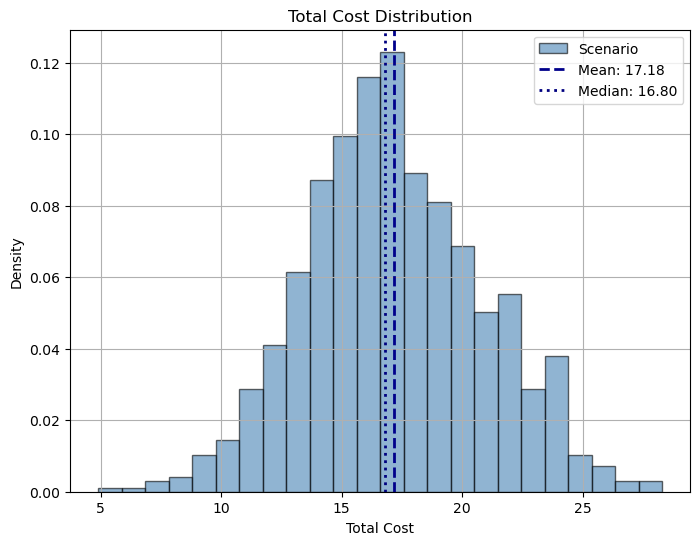

In [48]:
visualize_single_cost_distribution(total_costs)